## The project

**Manipuler le code cérébral en temps réel : de l’activité neuronale à la localisation spatiale dans un modèle murin de mémoire traumatique**

Peut-on identifier en temps réel des processus cérébraux liés à des mémoires spécifiques ? Si tel est le cas, peut-on manipuler ces mémoires en closed-loop, notamment pour en réduire l’aspect traumatique ?

Un type de mémoire ubiquitaire, facilement étudiable et manipulable est la mémoire liée à la navigation spatiale. En effet, la navigation spatiale chez les mammifères est principalement encodée et réactivée dans l’hippocampe, à l’aide de neurones spécialisés appelés cellules de lieu. À partir de leur activité, il est possible d’inférer la position réelle d’un rongeur en utilisant des méthodes probabilistes telles que l’inférence bayésienne. Cependant, ces approches reposent sur des hypothèses fortes et nécessitent un prétraitement conséquent, à la fois automatique et manuel, avant l’apprentissage du modèle.

L’objectif de ce hackathon est de concevoir une nouvelle méthode de décodage capable d’associer directement les données neuronales brutes de haute dimension (activité de spikes enregistrée dans l’hippocampe) à la position spatiale de l’animal. Cette localisation spatiale est un bon proxy du code neuronal, et le décodage pourra ainsi être appliqué pour inférer des réactivations spatiales lors de différents états de vigilance - lorsque l’animal rejoue les séquences neuronales associées à des expériences significatives pour consolider sa mémoire.
Dans une perspective de manipulation en closed-loop, l’outil devra également être interprétable, ou du moins fournir une mesure de confiance associée à chaque prédiction, afin de garantir sa fiabilité et sa pertinence.

Des approches prometteuses de deep learning développées au sein de notre laboratoire sont déjà en cours d’évaluation, mais doivent être testées, challengées et améliorées.

L’équipe aura accès à la position de souris naviguant librement dans un labyrinthe, associée aux spikes bruts (non triés) dans l’hippocampe sous forme de série temporelle. Des données supplémentaires seront mises à disposition selon l’imagination et le besoin de l’équipe.

## Loading the data

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import os
dataset_dir = os.path.abspath("dataset")

In [3]:
import pandas as pd
mouse = "M1199_PAG"
stride = 4
window_size = 108

def get_filename(mouse, stride, win, fformat = "tfrec"):
    if fformat in ["npy"]:
        return f"{mouse}_stride{stride}_win{win}_speedMask_hab&pre.{fformat}"
    return f"{mouse}_stride{stride}_win{win}_test.{fformat}"

**Two** dataset formats are available for you !
1. If you want to use tensorflow, the _TFRecord_ are directly available
2. If you want to try other libraries/methods, a plain _.parquet_ file is available

For every mouse, you also have access to a small _.json_ file, which will tell you how many channels you expect per group (see below).

### TFRec

In [4]:
import tensorflow as tf
tf.config.list_physical_devices()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Prevent TensorFlow from seizing all GPU memory immediately
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Found {len(gpus)} Physical GPU(s). Memory growth enabled.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU detected. Falling back to CPU.")

2026-02-04 12:32:02.973178: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-04 12:32:02.987623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770204723.004535  130173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770204723.009384  130173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-04 12:32:03.027250: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 1 Physical GPU(s). Memory growth enabled.


I0000 00:00:1770204724.366415  130173 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11971 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:ac:00.0, compute capability: 8.9


In [5]:
dataset_tfrec = tf.data.TFRecordDataset(os.path.join(dataset_dir, get_filename(mouse, stride, window_size)))

To read the ProtoBuff, you need to give tensorflow a description of features it is **expecting** to load.

In [6]:
featDesc = {'pos_index': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'pos': tf.io.VarLenFeature(dtype=tf.float32),
 'length': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'groups': tf.io.VarLenFeature(dtype=tf.int64),
 'time': tf.io.FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'time_behavior': tf.io.FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'indexInDat': tf.io.VarLenFeature(dtype=tf.int64),
 'speedMask': tf.io.VarLenFeature(dtype=tf.string),
 'group0': tf.io.VarLenFeature(dtype=tf.float32),
 'group1': tf.io.VarLenFeature(dtype=tf.float32),
 'group2': tf.io.VarLenFeature(dtype=tf.float32),
 'group3': tf.io.VarLenFeature(dtype=tf.float32),
 'group4': tf.io.VarLenFeature(dtype=tf.float32)}

In [7]:
def parse_function(feat_desc, ex_proto):
    tensors = tf.io.parse_example(serialized=ex_proto, features=featDesc)
    return tensors

In [8]:
def parse_dataset(*vals):
    return parse_function(featDesc, *vals)

In [9]:
dataset = dataset_tfrec.map(parse_dataset)

**Warning** : the dataset is batched with bachSize = 1

### Parquet

In [10]:
import pandas as pd

In [11]:
dataset_pq = pd.read_parquet(
    os.path.join(dataset_dir, get_filename(mouse, stride, window_size, fformat = "parquet"))
)

In [12]:
dataset_pq

,group0,group1,group2,group3,groups,indexInDat,length,pos,pos_index,time,time_behavior,speedMask,indexInDat_raw,indices0,zeroForGather,indices1,indices2,indices3
0,"[4.4905214, 4.289115, 2.397555, 4.9237323, 1.9...","[-2.7625754, -0.041320268, 1.1797833, 0.106313...","[-0.3823218, 0.26588744, -0.06600025, -2.07445...","[-11.746682, -9.458845, -10.755431, -9.787609,...","[1, 0, 2, 2, 0, 1, 0, 3, 1, 3, 0, 3, 2, 1, 3, ...","[216059597, 216059611, 216059622, 216059703, 2...",[73],"[0.2380991101561953, 0.8049437338425552, -2.89...",[156622],[10803.034],[10803.116],[False],"[216059597, 216059611, 216059622, 216059703, 2...","[0, 1, 0, 0, 2, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 4, 0, ...","[0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 0, 0, 4, ..."
1,"[4.744651, -0.46449965, -4.9791293, -1.4566978...","[-6.5401173, -9.58557, -5.05113, -4.1449285, -...","[1.3171366, 3.385435, 5.466522, 3.262233, 2.73...","[-6.449205, -3.7243226, -0.94095474, 4.024223,...","[0, 2, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 0, 2, ...","[216060331, 216060361, 216060368, 216060406, 2...",[66],"[0.2380991101561953, 0.8049437338425552, -2.89...",[156622],[10803.073],[10803.116],[False],"[216060331, 216060361, 216060368, 216060406, 2...","[1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...","[0, 0, 1, 2, 0, 0, 3, 4, 0, 5, 6, 7, 0, 0, 0, ..."
2,"[-4.867984, -2.0415728, -2.2092433, -2.701678,...","[-4.509027, -2.4044425, -4.283478, -8.628607, ...","[-3.866517, -3.463913, -1.9244556, -2.5225954,...","[-8.362156, -7.7195864, -5.204652, -9.035585, ...","[1, 0, 2, 1, 0, 1, 3, 1, 1, 0, 2, 2, 3, 1, 2, ...","[216061051, 216061065, 216061069, 216061083, 2...",[78],"[0.22347367133862373, 0.800746161144787, -3.03...",[156623],[10803.101],[10803.186],[True],"[216061051, 216061065, 216061069, 216061083, 2...","[0, 1, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 2, 0, 3, 0, 4, 5, 0, 0, 0, 0, 6, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 4, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, ..."
3,"[-7.8074355, -7.983128, -7.1518755, -12.03488,...","[-8.327696, -10.350467, -11.630261, -10.267146...","[1.3819051, 1.580239, 3.6971939, 0.8405953, -1...","[-9.0769, -12.542657, -14.468764, -10.566613, ...","[0, 3, 1, 2, 1, 0, 2, 0, 0, 2, 3, 1, 0, 0, 3, ...","[216061789, 216061794, 216061818, 216061830, 2...",[68],"[0.22347367133862373, 0.800746161144787, -3.03...",[156623],[10803.142],[10803.186],[True],"[216061789, 216061794, 216061818, 216061830, 2...","[1, 0, 0, 0, 0, 2, 0, 3, 4, 0, 0, 0, 5, 6, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, ..."
4,"[-5.3024197, -4.027823, -3.3042214, -7.5992155...","[7.775497, 2.7831135, 2.6834428, 1.9097018, 4....","[-3.9249418, -4.999227, -1.9690266, -3.817349,...","[6.3386106, 1.3817701, -4.808083, -1.6837108, ...","[0, 3, 0, 3, 2, 3, 1, 3, 2, 0, 3, 2, 0, 3, 3, ...","[216062512, 216062533, 216062582, 216062597, 2...",[64],"[0.2061004002545895, 0.8016716472082892, -3.08...",[156624],[10803.176],[10803.256],[True],"[216062512, 216062533, 216062582, 216062597, 2...","[1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, ...","[0, 1, 0, 2, 0, 3, 0, 4, 0, 0, 5, 0, 0, 6, 7, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62252,"[10.526662, 9.924886, 11.401096, 7.3240447, 4....","[9.117815, 11.62869, 9.467212, 8.861675, 6.113...","[11.300127, 7.9560633, 9.561236, 9

## Data format and prerequisites

For every example (be it batched or not), the dataset will consist of the following columns.

In [13]:
print(dataset_pq.columns)

Index(['group0', 'group1', 'group2', 'group3', 'groups', 'indexInDat',
       'length', 'pos', 'pos_index', 'time', 'time_behavior', 'speedMask',
       'indexInDat_raw', 'indices0', 'zeroForGather', 'indices1', 'indices2',
       'indices3'],
      dtype='str')


### Rationale

The idea of this dataset is the following : we have a recording in the hippocampus with a silicon probe or tetrode at very high sampling frequency (20 000 Hz). A probe consists in several shanks, or anatomical groups, that record electrophysiological data (ion currents in the brain) at different locations. We thus need to consider that each shank record functionnalyd different activity. We record in a very specific location of the hippocampus (CA1) which is known to be very informative on spatial locations, and have neurons that fire only at very specific locations in the space (Place Cells/Place Fields). Our hypothesis is that this information is more than enough to decode precise positions in a complex environmenent, only from neural activity.

For each timepoint of decoding, we have the real _(x,y)_ coordinates of the mouse in a closed environmnent. This timepoint can be expressed in seconds (`time/time_behavior`) or in indexes (`pos_index`) with $t_s = \frac{idx}{f_s}$, with $f_s$ usually around 15 Hz. For physiological reasons, the neural activity in terms of position encoding is only relevant when the mouse is moving (see Kay et al., 2016): to filter out relevant positions, you have access to the bool variable `speedMask`.

For each timepoint, ou goal is to map high-dimensional neural activity to a spatial position. We want the decoding to be independant of brain states and large oscillations in the brain. Thus, the dataset that you'll find here uses highpass-filtered data, focuses only on spikes activity. In order to construct that dataset, we process each shank independently:
- we look at the voltage in the last `x` ms (x is the size of the context window) preceding the decoding timepoint for every channel in the shank
- if one of the channels has a voltage higher than 3s.d. above mean, we consider this activity to be a "spike"
- we center around the peak of this activity and take the activity in every channel of the shank for the 15 timepoints before and 16 timepoints after the peak. This gives us single spikes with duration if 1.6ms ($32/20000 \approx 0.75ms$). For each spike, we note the `indexInDat` of the peak, which represents the index in the recording file. As above, $t_s = \frac{idxInDat}{f_s}$ with $f_s = 20000 ~Hz$. Each detected spike has a shape (nChannelsInShank, 32).
- usually, several spikes are found per context window. We simply stack the the spike info and the indexInDat together.

Once we have gathered all the spikes in every shank (hereby named `group`), we can build a more global sequence showing us which channel is active when, with respect to the other shanks. We simply do so by constructing a `groups` array, of length `length`, which represents the sums of spikes detected in each shank. The `groups` array simply represents the index of each group in the sequence.

For batch purposes (not every shank or group has the same amount of spikes detected in the same context window on one side, and not the other side not every sample/example has the same total number of spikes in a context window), we have to pad them using the `zeroForGather` array, which is 0-padded. The `indices` array represents when we should take a real spike, and when we should 0-pad.
This is how we would work in pseudocode:
- we are taking sample 1
- sample 1 has a length of `length`, which is the number of detected spikes across shanks.
```python
    spike_list = np.zeros((nShanks, length)) 
    for i in range(length):
      group_to_use = groups[i] --> will be 0, 1, 2 or 3 as we usually have 4 shanks
      spike_to_recollect = f"indices{group_to_use}"[i]
      if spike_to_recollect is 0:
          this is a fake spike for padding
      else:
          spike_to_take = f"group{group_to_use}"[spike_to_recollect]
      spike_list[group_to_use, i] = spike_to_take
```
- Like that, we can slowly reconstruct the sequence of spikes used in the context window
- **Caution**: currently, the `group0`, `group1` etc are flattened for storage. One needs to reshape them to (-1, nChannelsInShank, 32) to get the true spikes.

### What you get

For every mouse, you'll get one dataset in either the `tfrec` or `parquet` format. If you're using tensorflow, `tfrec` should be much faster for you. In any case, the data is pretty lightweight per mouse. 
The dataset consists only of behavioural experiments in a 40cm x 40cm U-shaped maze, where you have access to the (x,y) coordinates. The mouse is freely moving in  its environmenent and is slowly discovering it. It has never seen the U-Maze before.

For each mouse, you have access to 3 different datasets. The only change is the size of the context window (so how much in the past we have looked to collect individual spikes). You have:
- 36 ms --> very short timescale, few spikes per position but probably very informative.
- 108 ms --> mid timescale
- 252 ms --> "long" timescale, much more spikes but also more noise : in 252ms, the mouse may have moved a lot (40cm+) and the additional spikes might contain counter-productive information.


You also have access to a `.json` file which will will give you the number of recording shanks in that animal (nGroups), but also the number of channels in that shank.

### MWE 

In [14]:
import json

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

json_file = "M1199_PAG.json"

with open(os.path.join(dataset_dir, json_file), "r") as f:
    params = AttrDict(json.load(f))

featDesc = {'pos_index': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'pos': tf.io.VarLenFeature(dtype=tf.float32),
 'length': tf.io.FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'groups': tf.io.VarLenFeature(dtype=tf.int64),
 'time': tf.io.FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'indexInDat': tf.io.VarLenFeature(dtype=tf.int64),
           }

params.nChannelsPerGroup = []
for g in range(params.nGroups):
    params.nChannelsPerGroup.append(params[f"group{g}"]["nChannels"])
    featDesc[f"group{g}"] = tf.io.VarLenFeature(dtype=tf.float32)
    featDesc[f"indices{g}"] = tf.io.VarLenFeature(dtype=tf.int64)

In [15]:
import utils

# This function does the same as above in TFRec example, but reshape the groups automatically
# Even more, it already filters out the non-moving epochs using speedMask (see code in utils)
dataset_reshaped = utils.load_parsed_dataset(file_path=os.path.join(dataset_dir, get_filename(mouse, stride, window_size)), 
                                    params = params, 
                                    featDesc= featDesc, use_speedMask=True)

### Visualize the dataset

In [16]:
example = next(iter(dataset_reshaped))

2026-02-04 12:32:31.078121: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


In [17]:
example.keys()

dict_keys(['group0', 'group1', 'group2', 'group3', 'groups', 'indexInDat', 'indices0', 'indices1', 'indices2', 'indices3', 'pos', 'length', 'pos_index', 'time'])

In [18]:
example["group0"].shape

TensorShape([19, 6, 32])

Duration of this context window: 0.107s


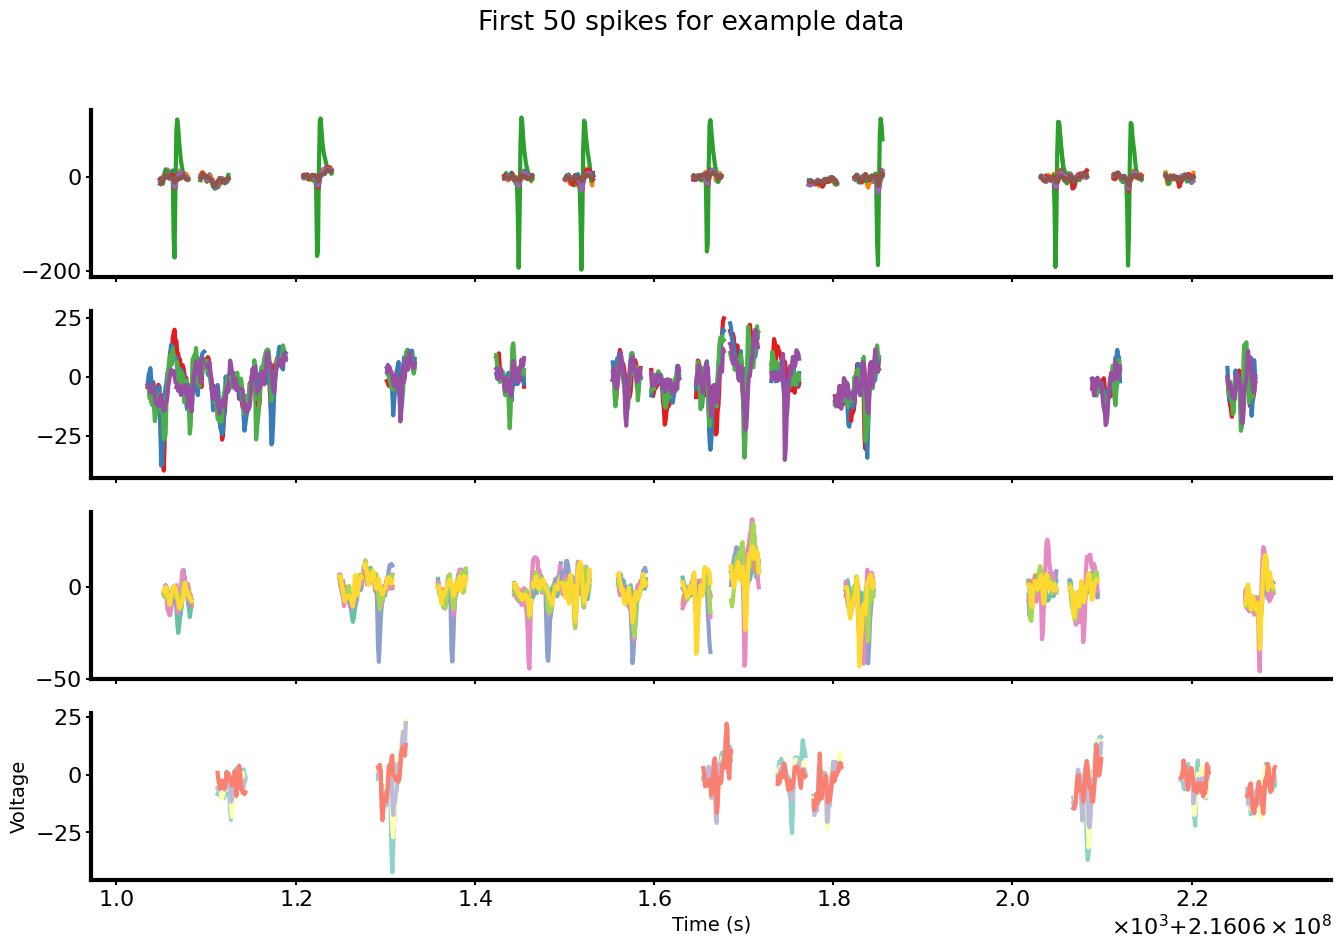

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, _axs = plt.subplots(params.nGroups, 1, sharex = True)
axs = _axs.flatten()
group_map = {
    i: {
        "data": example[f"group{i}"],
        "indices": example[f"indices{i}"],
        "cmap": [plt.get_cmap("tab10"), plt.get_cmap("Set1"), plt.get_cmap("Set2"), plt.get_cmap("Set3")][i],
        "ax": axs[i],
    } for i in range(params.nGroups)
}

min_time = example["indexInDat"][0]/20000
max_time = example["indexInDat"][-1]/20000

print(f"Duration of this context window: {max_time - min_time:.3f}s")


for i in range(min(50, example["length"].numpy())): # let's plot the first 50 spikes for this example !
    idx_group = example["groups"][i].numpy()
    target = group_map[idx_group]
    spike_idx = target["indices"][i].numpy()

    spike_to_plot = target["data"][spike_idx - 1] # --> if idx spike is 0 it means the spike was padded, so the first real spike begins at idx 1
    assert params.nChannelsPerGroup[idx_group] == spike_to_plot.shape[0]

    start_of_spike = example["indexInDat"][i] - 16
    time_of_spike = np.arange(start_of_spike, start_of_spike + 32)
    time_in_s = time_of_spike / 20000
    
    for ch in range(spike_to_plot.shape[0]):
        cmap = target["cmap"]
        ax = target["ax"]
        ax.plot(time_of_spike, spike_to_plot[ch, :], c = cmap(ch))

fig.suptitle("First 50 spikes for example data")
axs[-1].set_xlabel("Time (s)")
axs[-1].set_ylabel("Voltage")

plt.show()

### Build a dummy model

We will build a dummy model that processes the spikes from every shank independently (they are anatomically different!), merges the output and predicts a position.

In [20]:
dataset_reshaped

<_PrefetchDataset element_spec={'group0': TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), 'group1': TensorSpec(shape=(None, 4, 32), dtype=tf.float32, name=None), 'group2': TensorSpec(shape=(None, 6, 32), dtype=tf.float32, name=None), 'group3': TensorSpec(shape=(None, 4, 32), dtype=tf.float32, name=None), 'groups': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'indexInDat': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'indices0': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'indices1': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'indices2': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'indices3': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'pos': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'length': TensorSpec(shape=(), dtype=tf.int64, name=None), 'pos_index': TensorSpec(shape=(), dtype=tf.int64, name=None), 'time': TensorSpec(shape=(), dtype=tf.float32, name=None)}>

In [21]:
next(iter(dataset_reshaped)).keys()

dict_keys(['group0', 'group1', 'group2', 'group3', 'groups', 'indexInDat', 'indices0', 'indices1', 'indices2', 'indices3', 'pos', 'length', 'pos_index', 'time'])

In [22]:
# first, we want to reduce our pos target to 2D (x,y) instead of 4D (x,y) --> I let you guess what the 2 missing dimensions might be !!
def reduce_pos_dimension(example):
    example['pos'] = example['pos'][:2]
    return example

# then, we want to batch our dataset with padding (each example can have different number of spikes)
padded_shapes = {
    'groups': [None],
    'pos': [2], # For now 'pos' is 4D 
    'indexInDat': [None],
    'time': [],
    'length': [],
    'pos_index': [],
}
for g in range(params.nGroups):
    padded_shapes[f"group{g}"] = [None, params.nChannelsPerGroup[g], 32]  # Assuming each spike has shape (nChannels, 32)
    padded_shapes[f"indices{g}"] = [None]
    
# we put -1 everywhere, while keeping the correct dtype
padding_values = {
    "groups": tf.constant(-1, dtype=tf.int64),
    "pos": tf.constant(-1.0, dtype=tf.float32),
    "indexInDat": tf.constant(-1, dtype=tf.int64),
    "time": tf.constant(-1.0, dtype=tf.float32),
    "length": tf.constant(-1, dtype=tf.int64),
    "pos_index": tf.constant(-1, dtype=tf.int64),
}
for g in range(params.nGroups):
    padding_values[f"group{g}"] = tf.constant(-1.0, dtype=tf.float32)
    padding_values[f"indices{g}"] = tf.constant(0, dtype=tf.int32)

filtered_dataset = dataset_reshaped.map(reduce_pos_dimension, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size=256, padded_shapes=padded_shapes, padding_values=padding_values)

# we want to separate the actual dataset inputs from its output (the position here)
# currently the pos is 4D, I let you imagine what the 2 missing dimensions might be !!
def split_dataset(vals):
    pos = vals.pop("pos")
    inputs = vals
    return inputs, pos

dataset_splitted = filtered_dataset.map(split_dataset, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


In [23]:
nFeatures = 3
model = utils.build_dummy_model(params, nFeatures=nFeatures)

model.compile(
    optimizer='adam',
    loss='mse', # L2 Loss
    metrics=['mae']
)

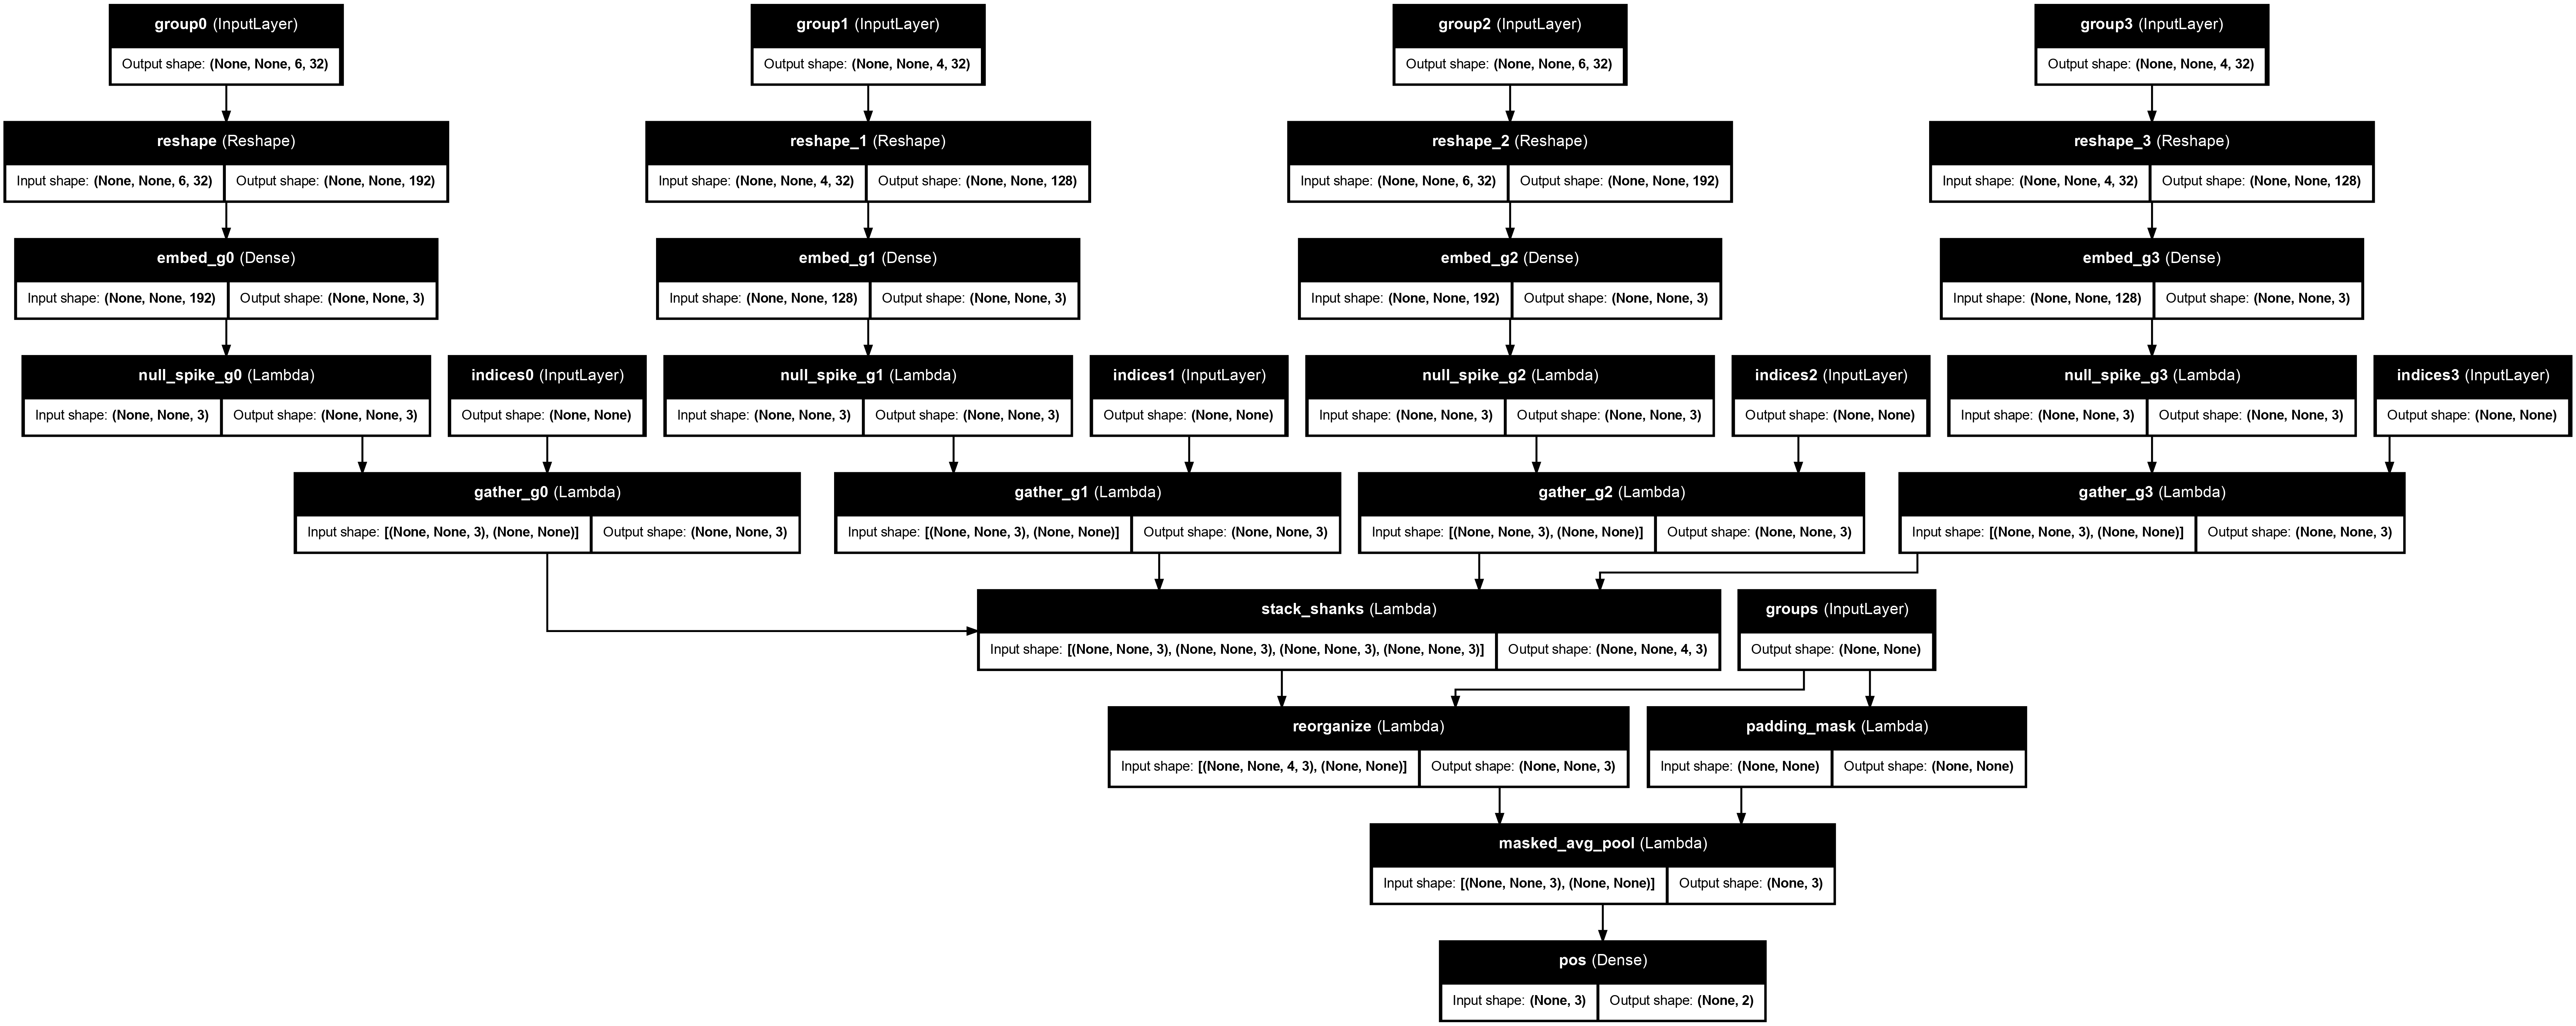

In [24]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ group0 (InputLayer) │ (None, None, 6,   │          0 │ -                 │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1 (InputLayer) │ (None, None, 4,   │          0 │ -                 │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2 (InputLayer) │ (None, None, 6,   │          0 │ -                 │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group3 (InputLayer) │ (None, None, 4,   │          0 │ -                 │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, None, 192) │          0 │ group0[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, None, 128) │          0 │ group1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, None, 192) │          0 │ group2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, None, 128) │          0 │ group3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_g0 (Dense)    │ (None, None, 3)   │        579 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_g1 (Dense)    │ (None, None, 3)   │        387 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_g2 (Dense)    │ (None, None, 3)   │        579 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_g3 (Dense)    │ (None, None, 3)   │        387 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ null_spike_g0       │ (None, None, 3)   │          0 │ embed_g0[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indices0            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ null_spike_g1       │ (None, None, 3)   │          0 │ embed_g1[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indices1            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ null_spike_g2       │ (None, None, 3)   │          0 │ embed_g2[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indices2            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ null_spike_g3       │ (None, None, 3)   │          0 │ embed_g3[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,940 (7.58 KB)

 Trainable params: 1,940 (7.58 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# try one pass to the model 
exampe = next(iter(dataset_splitted))
model(exampe[0])

<tf.Tensor: shape=(256, 2), dtype=float32, numpy=
array([[-1.54456844e+01,  6.70246792e+00],
       [-1.51550961e+01,  6.72176075e+00],
       [-1.40017538e+01,  5.20572805e+00],
       [-1.67491493e+01,  7.68678904e+00],
       [-1.44919529e+01,  5.64688635e+00],
       [-1.53268452e+01,  7.64901114e+00],
       [-1.44241848e+01,  5.32573748e+00],
       [-1.55764256e+01,  6.02481842e+00],
       [-1.57830992e+01,  5.09810591e+00],
       [-1.68418732e+01,  6.58166838e+00],
       [-1.73149300e+01,  5.46833277e+00],
       [-1.70099564e+01,  4.15520859e+00],
       [-1.78443432e+01,  4.86862659e+00],
       [-1.68253689e+01,  4.94341755e+00],
       [-1.42843418e+01,  3.93624282e+00],
       [-1.52716646e+01,  5.21165419e+00],
       [-1.60202866e+01,  4.85966253e+00],
       [-1.66103401e+01,  5.02727604e+00],
       [-1.54679184e+01,  3.76026344e+00],
       [-1.69981441e+01,  6.06988049e+00],
       [-1.73871040e+01,  6.16390133e+00],
       [-1.63240681e+01,  6.21088076e+00],
    

In [28]:
# this model is more than unoptimized, but it should work as a first try !
model.fit(dataset_splitted, epochs = 10)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.1989 - mae: 0.3598
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.1815 - mae: 0.3461
Epoch 3/10
 1/90 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.0860 - mae: 0.2388

2026-02-04 13:46:57.026218: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17743753939083841957
2026-02-04 13:46:57.026282: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7352401807763214764
2026-02-04 13:46:57.026305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2905353898188661156


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.1674 - mae: 0.3354
Epoch 4/10
 2/90 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0971 - mae: 0.2576  

2026-02-04 13:47:03.058076: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17743753939083841957
2026-02-04 13:47:03.058135: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7352401807763214764
2026-02-04 13:47:03.058246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2905353898188661156


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.1554 - mae: 0.3265
Epoch 5/10
 3/90 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0949 - mae: 0.2569 

2026-02-04 13:47:08.942803: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2498956798028261449
2026-02-04 13:47:08.942861: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17743753939083841957
2026-02-04 13:47:08.942877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1710193309125919233
2026-02-04 13:47:08.942888: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 252579009338021175
2026-02-04 13:47:08.942899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13915319862290935667
2026-02-04 13:47:08.942915: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 8575529113777418368
2026-02-04 13:47:08.942926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv it

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1460 - mae: 0.3195
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1385 - mae: 0.3141
Epoch 7/10
 3/90 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0881 - mae: 0.2528  

2026-02-04 13:47:16.602104: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_18]]
2026-02-04 13:47:16.602146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17743753939083841957
2026-02-04 13:47:16.602155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13915319862290935667
2026-02-04 13:47:16.602165: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7352401807763214764
2026-02-04 13:47:16.602211: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2905353898188661156


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1321 - mae: 0.3098
Epoch 8/10
 3/90 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0865 - mae: 0.2534  

2026-02-04 13:47:20.558922: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17743753939083841957
2026-02-04 13:47:20.558964: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7352401807763214764


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.1270 - mae: 0.3064
Epoch 9/10
 3/90 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0856 - mae: 0.2545  

2026-02-04 13:47:24.546570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17743753939083841957
2026-02-04 13:47:24.546611: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13915319862290935667
2026-02-04 13:47:24.546622: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 7352401807763214764
2026-02-04 13:47:24.546661: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2905353898188661156


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1229 - mae: 0.3036
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.1196 - mae: 0.3016


In [35]:
# test the model output (here will be completely dumb, but it's just to check that everything works)
example = next(iter(dataset_splitted))
output = model.predict(example[0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


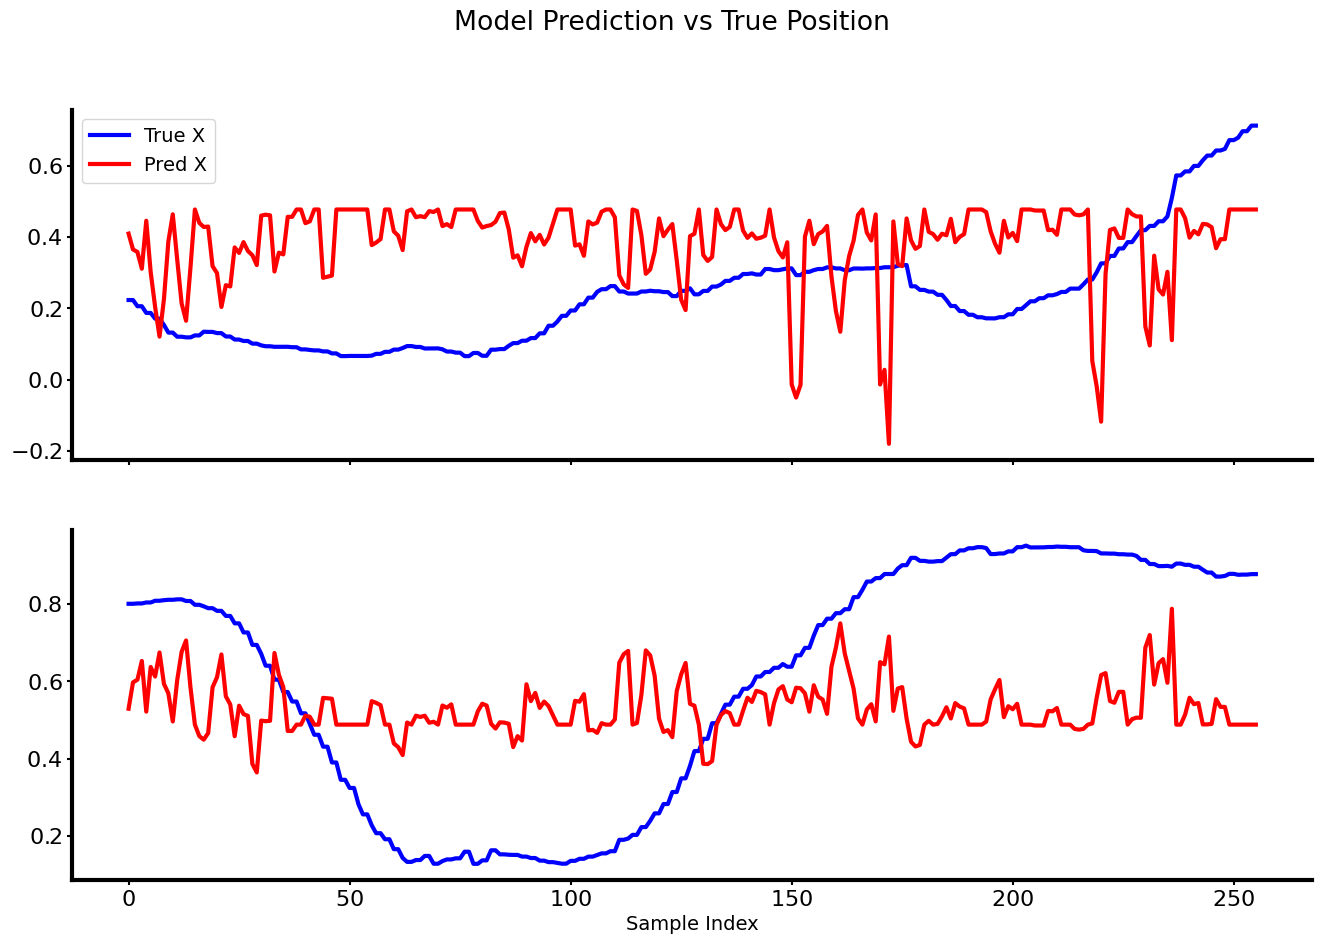

In [36]:
fig, axs = plt.subplots(2, 1, sharex = True)
axs[0].plot(example[1][:, 0], 'b', label = "True X")
axs[0].plot(output[:, 0], 'r', label = "Pred X")
axs[1].plot(example[1][:, 1], 'b', label = "True Y")
axs[1].plot(output[:, 1], 'r', label = "Pred Y")
axs[0].legend()
fig.suptitle("Model Prediction vs True Position")
plt.xlabel("Sample Index")
plt.show()